In [1]:
import pandas as pd
import numpy as np
import traffic
from traffic.core import Traffic
from traffic.data import opensky
from traffic.data import airports
import matplotlib.pyplot as plt
import datetime
import importlib
from matplotlib.backends.backend_pdf import PdfPages
from openap import prop
from tqdm import tqdm 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

%load_ext autoreload
%autoreload 2
import agps_funs

***
# Download and preprocessing of trajs
***

In [2]:
airport_str = 'LSZH'

### Downloading trajs

In [54]:
start = "2024-06-01 00:00"
stop = "2024-06-02 23:59"

timestamps = pd.date_range(start, stop, freq="4h")
data = []
for t1, t2 in zip(timestamps[:-1], timestamps[1:]):
        tmp = opensky.history(start=str(t1), stop=str(t2), bounds=airports[airport_str].shape.convex_hull.buffer(0.1))
        if tmp is not None:
            data.append(tmp.data)
        

trajs = pd.concat(data)
trajs = Traffic(trajs)

EXECUTE IMMEDIATE not available for trino.opensky-network.org:443; defaulting to legacy prepared statements (TrinoUserError(type=USER_ERROR, name=SYNTAX_ERROR, message="line 1:19: mismatched input ''SELECT 1''. Expecting: 'USING', <EOF>", query_id=20240822_071754_54898_m444c))
FINISHED: : 100% [00:09, 10.1%/s]
DOWNLOAD: 22.8klines [00:00, 567klines/s]
RUNNING: : 76.1% [00:12, 5.99%/s]
DOWNLOAD: 325klines [00:49, 6.62klines/s]
RUNNING: : 76.5% [00:11, 6.39%/s]
DOWNLOAD: 434klines [01:11, 6.08klines/s]
RUNNING: : 76.3% [00:10, 7.43%/s]
DOWNLOAD: 317klines [00:50, 6.29klines/s]
RUNNING: : 75.2% [00:10, 7.47%/s]
DOWNLOAD: 235klines [00:33, 7.01klines/s]
RUNNING: : 76.6% [00:10, 7.64%/s]
DOWNLOAD: 111klines [00:13, 8.11klines/s]
FINISHED: : 100% [00:09, 10.3%/s]
DOWNLOAD: 34.7klines [00:00, 428klines/s]
RUNNING: : 77.0% [00:10, 7.52%/s]
DOWNLOAD: 312klines [00:46, 6.68klines/s]
RUNNING: : 92.6% [00:13, 6.94%/s]
DOWNLOAD: 427klines [01:10, 6.02klines/s]
RUNNING: : 76.5% [00:10, 6.97%/s]
DOWN

### Preprocessing and pickling

In [55]:
# Reduce to lat/lon & altitude of interest
gnd_trajs = trajs.query('altitude<4000 or onground')
gnd_trajs = gnd_trajs.assign_id().resample('1s').eval(max_workers=8, desc='resampling')
gnd_trajs = gnd_trajs.aircraft_data()
gnd_trajs = gnd_trajs.cumulative_distance().eval(max_workers=8, desc='cumdist')

gnd_trajs.to_pickle(airport_str+'_raw_JUN.pkl')

resampling:   0%|          | 0/1979 [00:00<?, ?it/s]

cumdist:   0%|          | 0/1979 [00:00<?, ?it/s]

## Load gnd_trajs from Pickle (only if required)

In [3]:
gnd_trajs = Traffic.from_file(airport_str+'_gnd_JUN.pkl')

*** 
# Define Geometries for Runways and Stands
***

In [6]:
from shapely.geometry import LineString
import numpy as np
from cartes.crs import EuroPP
import cartopy.crs as ccrs
data_proj = ccrs.PlateCarree()


# Function to extend a point in the direction of another point
def extend_point(p1, p2, distance):
    # Calculate direction vector
    direction = np.array(p2) - np.array(p1)
    direction = direction / np.linalg.norm(direction)  # Normalize the vector
    # Extend the point
    new_point = np.array(p1) - direction * distance
    return tuple(new_point)

# Create Runway Geometries
rwys = []
idx = [0, 2, 4]

for i in idx:

    lat1 = airports[airport_str].runways.data.latitude[i]
    lon1 = airports[airport_str].runways.data.longitude[i]
    lat2 = airports[airport_str].runways.data.latitude[i+1]
    lon2 = airports[airport_str].runways.data.longitude[i+1]


    # Define the coordinates of the two points
    point1 = (lon1, lat1)
    point2 = (lon2, lat2)

    # Create a LineString object
    rwy = LineString([point1, point2])

    # Extend both ends of the line
    extension_distance = 0.002  # Adjust this value as needed
    rwy_extended = LineString([extend_point(point2, point1, extension_distance),
                            extend_point(point1, point2, extension_distance)])


    rwy_extended = rwy_extended.buffer(distance=0.0004, cap_style='square')

    rwys.append(rwy_extended)


In [7]:
from shapely.geometry import Polygon
data_proj = ccrs.PlateCarree()

stands = []

# # Dock E Stands
# stands.append(Polygon(shell=((8.559361, 47.461887),
#                              (8.549978, 47.462542),
#                              (8.551437, 47.460347),
#                              (8.559075, 47.459822))))


# Dock E Stands (area slightly extended in order to improve pushback detection)
stands.append(Polygon(shell=((8.549924, 47.462661),
                             (8.551635, 47.460186),
                             (8.559250, 47.459671),
                             (8.559618, 47.462015))))

# Dock A Stands
stands.append(Polygon(shell=((8.555001, 47.454855),
                             (8.556140, 47.453175),
                             (8.560965, 47.452810),
                             (8.562083, 47.454330))))

# # Dock B Stands
# stands.append(Polygon(shell=((8.560488, 47.451963),
#                              (8.556346, 47.452250),
#                              (8.557920, 47.450010),
#                              (8.560157, 47.449799))))

# Dock B Stands (area slightly extended in order to improve pushback detection)
stands.append(Polygon(shell=((8.556163, 47.452404),
                             (8.558079, 47.449825),
                             (8.559995, 47.449686),
                             (8.560519, 47.452131))))

# Charlie Stands
stands.append(Polygon(shell=((8.560601, 47.448472),
                             (8.562883, 47.445380),
                             (8.563924, 47.445758),
                             (8.561669, 47.448833))))

# Golf Stands (east part)
stands.append(Polygon(shell=((8.562589, 47.440829),
                             (8.561054, 47.443088),
                             (8.560208, 47.442844),
                             (8.561806, 47.440590))))

# Golf Stands (west part)
stands.append(Polygon(shell=((8.563977, 47.441257),
                             (8.563025, 47.442721),
                             (8.562171, 47.442462),
                             (8.563191, 47.441011))))

# Papa Stands
stands.append(Polygon(shell=((8.551049, 47.463711),
                             (8.550944, 47.463068),
                             (8.553608, 47.462883),
                             (8.553666, 47.463552))))

# Tango Stands
stands.append(Polygon(shell=((8.561366, 47.443951),
                             (8.562294, 47.443334),
                             (8.563789, 47.443741),
                             (8.563284, 47.444532))))

# Whiskey Stands
stands.append(Polygon(shell=((8.546829, 47.454721),
                             (8.545534, 47.454426),
                             (8.547307, 47.452003),
                             (8.548511, 47.452336))))

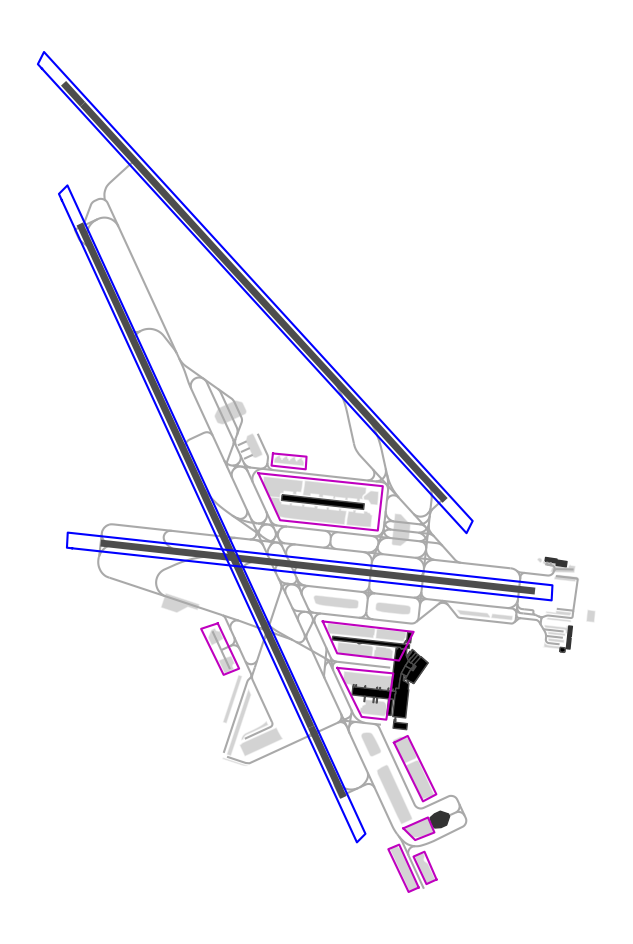

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
ax.spines["geo"].set_visible(False)

for rwy in rwys:
    ax.plot(*rwy.exterior.xy, transform=data_proj, color = 'b')

for stand in stands:
    ax.plot(*stand.exterior.xy, transform=data_proj, color = 'm')


plt.show()

***
# Determine Take-off Runway, Taxi-Times, etc.
***

**Known issues:**
* Noisy gnd trajs -> SWR52_1040, SWR252H_992, SAZ71_1319, SWR2HB_949, KLM38Y_350, SWR95H_1307, EDW58T_1127
* JUL: First part of taxi not classified as taxi -> ETD74_2332


**Missing Functionalities:**
* Filter take-offs with taxiway filter
* Implement Fuel Flow Estimation -> for Engine, APU & Tractor (see Figure 8 in Fleuti & Maraini 2017, p.16)


(0.0, 10.0)

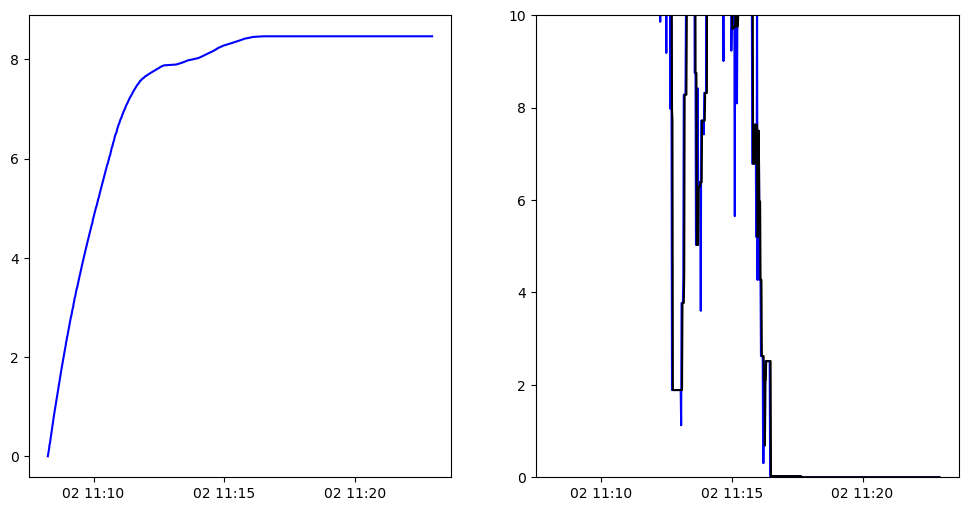

In [120]:
id = 'SFG55A_158'

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(gnd_trajs[id].data.timestamp,
         gnd_trajs[id].data.cumdist, 'b')

# ax[0].plot(gnd_trajs[id].pushback('lszh').data.timestamp,
#          gnd_trajs[id].pushback('lszh').data.cumdist, 'r')

# ax[0].plot(gnd_trajs[id].on_parking_position('lszh').max().data.timestamp,
#          gnd_trajs[id].on_parking_position('lszh').max().data.cumdist, 'g')

# ax[0].plot(gnd_trajs[id].clip(standsDockE).data.timestamp,
#            gnd_trajs[id].clip(standsDockE).data.cumdist, 'm')


ax[1].plot(gnd_trajs[id].data.timestamp,
           gnd_trajs[id].data.compute_gs, 'b')

ax[1].plot(gnd_trajs[id].data.timestamp,
           gnd_trajs[id].data.compute_gs.rolling(5).median(), 'k')

ax[1].set_ylim(0, 10) 

#ax[1].set_xlim('2024-07-01 14:00:00', '2024-07-01 14:10:00')




**Pusback modification**:

1. Check cumdist of pushback
2. IF larger than certain value
3. Check if trajectory.clip(standsArea) is not None
4. If this applies, use the part of compute_gs>0 which intersects with clipped part of trajectory

In [16]:
import agps_funs
importlib.reload(agps_funs)
from agps_funs import alternative_pushback_detection
from agps_funs import takeoff_detection

In [65]:
id = 'AUA554Z_227'


df_rwys = airports[airport_str].runways.data
bla = takeoff_detection(gnd_trajs[id], rwys, df_rwys)

bla.data

,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,onground,alert,...,compute_gs,compute_track,lineupTime,takeoffRunway,isTakeoff,isPushback,startPushback,startTaxi,pushbackDuration,taxiDuration
188518,2024-06-02 17:13:08+00:00,44065b,47.455153,8.556202,NaN,NaN,NaN,AUA554Z,1.0,0.0,...,6.092853,78.892906,2024-06-02 17:23:34+00:00,32,True,False,NaT,2024-06-02 17:13:08+00:00,NaT,0 days 00:08:14
188519,2024-06-02 17:13:09+00:00,44065b,47.455159,8.556242,NaN,NaN,NaN,AUA554Z,1.0,0.0,...,6.092853,78.892906,2024-06-02 17:23:34+00:00,32,True,False,NaT,2024-06-02 17:13:08+00:00,NaT,0 days 00:08:14
188520,2024-06-02 17:13:10+00:00,44065b,47.455164,8.556283,NaN,NaN,NaN,AUA554Z,1.0,0.0,...,6.092853,78.892905,2024-06-02 17:23:34+00:00,32,True,False,NaT,2024-06-02 17:13:08+00:00,NaT,0 days 00:08:14
188521,2024-06-02 17:13:11+00:00,44065b,47.455170,8.556324,NaN,NaN,NaN,AUA554Z,1.0,0.0,...,6.092852,78.892903,2024-06-02 17:23:34+00:00,32,True,False,NaT,2024-06-02 17:13:08+00:00,NaT,0 days 00:08:14
188522,2024-06-02 17:13:12+00:00,44065b,47.455165,8.556413,NaN,NaN,NaN,AUA554Z,1.0,0.0,...,13.071537,94.414181,2024-06-02 17:23:34+00:00,32,True,False,NaT,2024-06-02 17:13:08+00:00,NaT,0 days 00:08:14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189353,2024-06-02 17:27:03+00:00,44065b,47.512711,8.504860,164.0,329.995079,2112.0,AUA554Z,0.0,0.0,...,153.376252,329.607761,2024-06-02 17:23:34+00:00,32,True,False,NaT,2024-06-02 17:13:08+00:00,NaT,0 days 00:08:14
189354,2024-06-02 17:27:04+00:00,44065b,47.513262,8.504404,163.0,330.298590,2112.0,AUA554Z,0.0,0.0,...,136.643538,330.749660,2024-06-02 17:23:34+00:00,32,True,False,NaT,2024-06-02 17:13:08+00:00,NaT,0 days 00:08:14
189355,2024-06-02 17:27:05+00:00,44065b,47.513867,8.503911,163.0,330.298590,2112.0,AUA554Z,0.0,0.0,...,149.385962,331.106658,2024-06-02 17:23:34+00:00,32,True,False,NaT,2024-06-02 17:13:08+00:00,NaT,0 days 00:08:14
189356,2024-06-02 17:27:06+00:00,44065b,47.514450,8.503418,163.0,330.298590,2112.0,AUA554Z,0.0,0.0,...,145.147186,330.179421,2024-06-02 17:23:34+00:00,32,True,False,NaT,2024-06-02 17:13:08+00:00,NaT,0 days 00:08:14


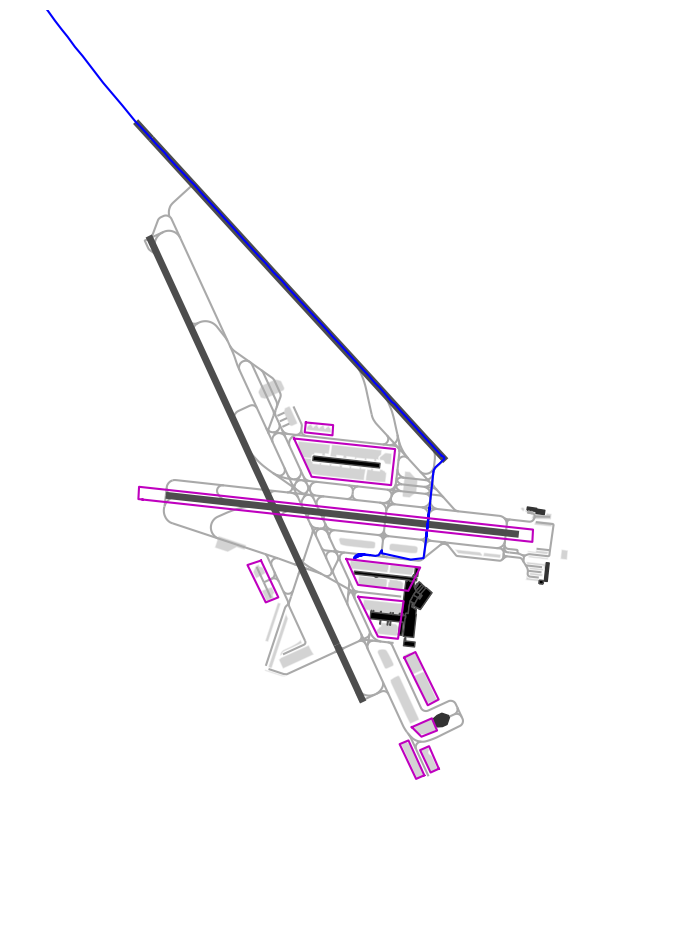

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
ax.spines["geo"].set_visible(False)

id = 'AUA554Z_227'

df_rwys = airports[airport_str].runways.data

gnd_trajs[id].last(minutes=60).plot(ax=ax, color='b')


ax.plot(*rwys[0].exterior.xy, transform=data_proj, color = 'm')

for stand in stands:
    ax.plot(*stand.exterior.xy, color = 'm', transform=data_proj)

ax.set_extent((8.5230, 8.5855, 47.4904, 47.4306))

plt.show()

### Takeoff Runway Detection

In [66]:
########
# Determine Take-off Runway (NEW, PARAELLIZED method)
########

# import warnings

# # Convert warnings to errors
# warnings.filterwarnings('error')
 
import agps_funs
importlib.reload(agps_funs)
from agps_funs import takeoff_detection

# Get aerodrome information
df_rwys = airports[airport_str].runways.data


gnd_trajs = gnd_trajs.iterate_lazy().pipe(takeoff_detection, rwys, df_rwys, 'lszh').eval(max_workers=8, desc='Takeoff Detection')

Takeoff Detection:   0%|          | 0/1979 [00:00<?, ?it/s]

### Pushback Detection

In [18]:
########
# Alternative Pushback Detection Method
# Is only applicable if taxi duration is less than 0 seconds (which origin from bug in traffics flight.pushback() method)
########

importlib.reload(agps_funs)
from agps_funs import alternative_pushback_detection

gnd_trajs = gnd_trajs.iterate_lazy().pipe(alternative_pushback_detection, stands).eval(max_workers=8, desc='Pushback Detection')


Pushback Detection:   0%|          | 0/1979 [00:00<?, ?it/s]

/Users/wate/opt/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:1770: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  | Callable[[pd.DataFrame], pd.DataFrame] = lambda x: x.bfill().ffill(),
/Users/wate/opt/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:1770: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  | Callable[[pd.DataFrame], pd.DataFrame] = lambda x: x.bfill().ffill(),
/Users/wate/opt/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:1770: FutureWarning: Downcasting object

In [ ]:
importlib.reload(agps_funs)
from agps_funs import normalTaxiFuel, extAGPSTaxiFuel

normalTaxiFuel(gnd_trajs[15])

In [9]:
importlib.reload(agps_funs)
from agps_funs import normalTaxiFuel, extAGPSTaxiFuel

gnd_trajs = gnd_trajs.iterate_lazy().pipe(normalTaxiFuel).eval(max_workers=8, desc='Taxi Fuel')
gnd_trajs = gnd_trajs.iterate_lazy().pipe(extAGPSTaxiFuel).eval(max_workers=8, desc='External AGPS')

Taxi Fuel:   0%|          | 0/1979 [00:00<?, ?it/s]

External AGPS:   0%|          | 0/1979 [00:00<?, ?it/s]

In [14]:
gnd_trajs.query('MESengine>0').data

,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,onground,alert,...,startPushback,startTaxi,pushbackDuration,taxiDuration,taxiDistance,MESengine,MESapu,normTAXIengine,extAGPSapu,extAGPSfuel
2768673,2024-06-01 09:24:28+00:00,aaf828,47.460526,8.556255,NaN,NaN,NaN,AAL93,1.0,0.0,...,2024-06-01 09:43:45+00:00,2024-06-01 09:45:08+00:00,0 days 00:01:23,0 days 00:10:04,0.703120,93.66,16.666667,269.384,24.064444,NaN
2768674,2024-06-01 09:24:29+00:00,aaf828,47.460526,8.556255,NaN,NaN,NaN,AAL93,1.0,0.0,...,2024-06-01 09:43:45+00:00,2024-06-01 09:45:08+00:00,0 days 00:01:23,0 days 00:10:04,0.703120,93.66,16.666667,269.384,24.064444,NaN
2768675,2024-06-01 09:24:30+00:00,aaf828,47.460526,8.556255,NaN,NaN,NaN,AAL93,1.0,0.0,...,2024-06-01 09:43:45+00:00,2024-06-01 09:45:08+00:00,0 days 00:01:23,0 days 00:10:04,0.703120,93.66,16.666667,269.384,24.064444,NaN
2768676,2024-06-01 09:24:31+00:00,aaf828,47.460527,8.556255,NaN,NaN,NaN,AAL93,1.0,0.0,...,2024-06-01 09:43:45+00:00,2024-06-01 09:45:08+00:00,0 days 00:01:23,0 days 00:10:04,0.703120,93.66,16.666667,269.384,24.064444,NaN
2768677,2024-06-01 09:24:32+00:00,aaf828,47.460527,8.556255,NaN,NaN,NaN,AAL93,1.0,0.0,...,2024-06-01 09:43:45+00:00,2024-06-01 09:45:08+00:00,0 days 00:01:23,0 days 00:10:04,0.703120,93.66,16.666667,269.384,24.064444,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33838,2024-06-02 07:45:33+00:00,3444cb,47.461869,8.494897,151.0,276.088528,2624.0,VLG5YD,0.0,0.0,...,NaT,2024-06-02 07:39:15+00:00,NaT,0 days 00:03:56,0.739248,44.94,8.000000,50.504,NaN,NaN
33839,2024-06-02 07:45:34+00:00,3444cb,47.461945,8.493874,151.0,276.088528,2560.0,VLG5YD,0.0,0.0,...,NaT,2024-06-02 07:39:15+00:00,NaT,0 days 00:03:56,0.739248,44.94,8.000000,50.504,NaN,NaN
33840,2024-06-02 07:45:35+00:00,3444cb,47.462036,8.492432,150.0,276.508956,2432.0,VLG5YD,0.0,0.0,...,NaT,2024-06-02 07:39:15+00:00,NaT,0 days 00:03:56,0.739248,44.94,8.000000,50.504,NaN,NaN
33841,2024-06-02 07:45:36+00:00,3444cb,47.462101,8.491939,150.0,276.508956,2304.0,VLG5YD,0.0,0.0,...,NaT,2024-06-02 07:39:15+00:00,NaT,0 days 00:03:56,0.739248,44.94,8.000000,50.504,NaN,NaN


In [19]:
gnd_trajs.to_pickle(airport_str+'_gnd_JUN.pkl')

In [20]:
# Generate df_movements

# Group by 'flight_id'
grouped = gnd_trajs.query('takeoffRunway != ""').groupby('flight_id')

# Create a new DataFrame df_movements to store the summarized data
df_movements = pd.DataFrame()

# Extract the required information
df_movements['flight_id'] = grouped['flight_id'].first()
df_movements['callsign'] = grouped['callsign'].first()
df_movements['isPushback'] = grouped['isPushback'].first()
df_movements['startPushback'] = grouped['startPushback'].first()
df_movements['startTaxi'] = grouped['startTaxi'].first()
df_movements['lineupTime'] = grouped['lineupTime'].first()
df_movements['taxiDuration'] = grouped['taxiDuration'].first()
df_movements['taxiDistance'] = grouped['taxiDistance'].first()
df_movements['takeoffRunway'] = grouped['takeoffRunway'].first()
df_movements['typecode'] = grouped['typecode'].first()


# Reset index to get a clean DataFrame
df_movements = df_movements.reset_index(drop=True)

df_movements.to_pickle('df_movements.pkl')

### Compare takeoff_from_runway() with my method

In [77]:
# Compare 
r = []

# Iterate over each flight_id in df_movements
for flight_id in df_movements['flight_id'].values:
    
    # Get the takeoff runway for the current flight_id
    tmp = gnd_trajs[flight_id].takeoff_from_runway('lszh').next()

    # If a runway is found, append it to the list, otherwise append None or a default value
    if tmp is not None:
        r.append(tmp.data.iloc[0].runway)
    else:
        r.append(None)  # or another placeholder like 'Unknown'

# Add the list `r` as a new column in df_movements
df_movements['runway'] = r


df_movements

,flight_id,callsign,taxi_start,line_up_time,taxi_duration,takeoff_runway,runway
0,AAL93_2363,AAL93,2024-07-01 12:18:08+00:00,2024-07-01 12:21:04+00:00,0 days 00:02:56,32,32
1,AAL93_2365,AAL93,2024-07-02 09:56:57+00:00,2024-07-02 09:59:28+00:00,0 days 00:02:31,32,32
2,AEA1676_049,AEA1676,2024-07-01 09:30:26+00:00,2024-07-01 09:34:43+00:00,0 days 00:04:17,32,32
3,AEA32KC_030,AEA32KC,2024-07-01 17:14:23+00:00,2024-07-01 17:21:31+00:00,0 days 00:07:08,32,32
4,AEA32KC_036,AEA32KC,2024-07-02 16:55:06+00:00,2024-07-02 17:02:42+00:00,0 days 00:07:36,32,32
...,...,...,...,...,...,...,...
690,VLG5YD_032,VLG5YD,2024-07-02 07:46:51+00:00,2024-07-02 07:54:14+00:00,0 days 00:07:23,28,10
691,VLG5YD_045,VLG5YD,2024-07-01 10:11:19+00:00,2024-07-01 10:18:35+00:00,0 days 00:07:16,32,32
692,VLG6473_035,VLG6473,2024-07-02 13:08:22+00:00,2024-07-02 13:13:15+00:00,0 days 00:04:53,32,14
693,XAFTY_016,XAFTY,2024-07-02 13:11:14+00:00,2024-07-02 13:17:43+00:00,0 days 00:06:29,32,32


In [95]:
df_movements['is_identical'] = df_movements['TO_runway'] == df_movements['runway']
num_differences = df_movements['is_identical'].value_counts()[False]

# Percentace of differences between takeoff_from_runway() and my method:
print(num_differences/len(df_movements))

# Which runways are not identified properly?
differences = df_movements[df_movements['TO_runway'] != df_movements['runway']]
mismatched_values = differences[['flight_id', 'takeoff_runway', 'runway']]

# Group by TO_runway and runway, then count the occurrences
df_movements.groupby(['takeoff_runway', 'runway']).size().reset_index(name='count')

0.2839160839160839


,TO_runway,runway,count
0,16,16,16
1,28,10,25
2,28,28,128
3,32,10,2
4,32,14,142
5,32,16,18
6,32,28,2
7,32,32,356
8,34,16,2
9,34,34,12


### Load df_movements from pickle (only if required)

In [109]:
df_movements = pd.read_pickle('df_movements.pkl')
df_movements

,flight_id,callsign,isPushback,startPushback,startTaxi,lineupTime,taxiDuration,taxiDistance,takeoffRunway,typecode
0,9AJIM_1791,9AJIM,False,NaT,2024-06-02 18:21:44+00:00,2024-06-02 18:25:05+00:00,0 days 00:03:21,0.567781,32,C525
1,AAL93_1964,AAL93,True,2024-06-01 09:43:45+00:00,2024-06-01 09:45:08+00:00,2024-06-01 09:55:12+00:00,0 days 00:10:04,0.703120,28,B788
2,AAL93_1966,AAL93,True,2024-06-02 09:50:42+00:00,2024-06-02 09:52:13+00:00,2024-06-02 10:03:36+00:00,0 days 00:11:23,0.759994,28,B788
3,ACA881_1975,ACA881,True,2024-06-02 11:30:45+00:00,2024-06-02 11:32:02+00:00,2024-06-02 11:42:24+00:00,0 days 00:10:22,1.444709,16,B77W
4,ACA881_1978,ACA881,True,2024-06-01 11:28:38+00:00,2024-06-01 11:28:59+00:00,2024-06-01 11:39:38+00:00,0 days 00:10:39,1.326674,16,A333
...,...,...,...,...,...,...,...,...,...,...
718,VLG5YD_047,VLG5YD,False,NaT,2024-06-02 07:39:15+00:00,2024-06-02 07:43:11+00:00,0 days 00:03:56,0.739248,28,A320
719,VPBIB_192,VPBIB,False,NaT,2024-06-02 14:18:27+00:00,2024-06-02 14:42:43+00:00,0 days 00:24:16,0.172802,28,C25C
720,VQBHK_194,VQBHK,False,NaT,2024-06-02 08:20:11+00:00,2024-06-02 08:24:08+00:00,0 days 00:03:57,0.868492,28,None
721,VTTUS_1927,VTTUS,False,NaT,2024-06-02 12:25:44+00:00,2024-06-02 12:35:22+00:00,0 days 00:09:38,0.698260,28,None


***
# Some stats
***

### Daten aus dem Lärmbulletin der FZAG

| Datum     | RWY 10 | RWY 16 | RWY 28 | RWY 32 | RWY 34 | TOTAL  |
|-----------|-------:|-------:|-------:|-------:|-------:|-------:|
| 01.06.24  | 0      | 36     | 235    | 84     | 3      | 358    |
| 02.06.24  | 0      | 35     | 225    | 131    | 6      | 397    |
| Jun01+02  | 0      | 71     | 460    | 215    | 9      | 755    |
| Jun24     | 0      | 1151   | 7309   | 2826   | 155    | 11441  |

In [110]:
# Group by TO_runway and calculate mean and std
overview = df_movements.groupby('takeoffRunway')['taxiDuration'].agg(['count', 'mean', 'std']).reset_index()

# Display the result
overview

,takeoffRunway,count,mean,std
0,10,1,0 days 00:08:14,NaT
1,16,69,0 days 00:12:02.318840579,0 days 00:04:11.036527266
2,28,460,0 days 00:06:52.408695652,0 days 00:04:51.844271472
3,32,186,0 days 00:06:44.091397849,0 days 00:06:35.215462591
4,34,7,0 days 00:04:27.428571428,0 days 00:04:34.419300306


***
# Some illustrations
***

### Check runway classification

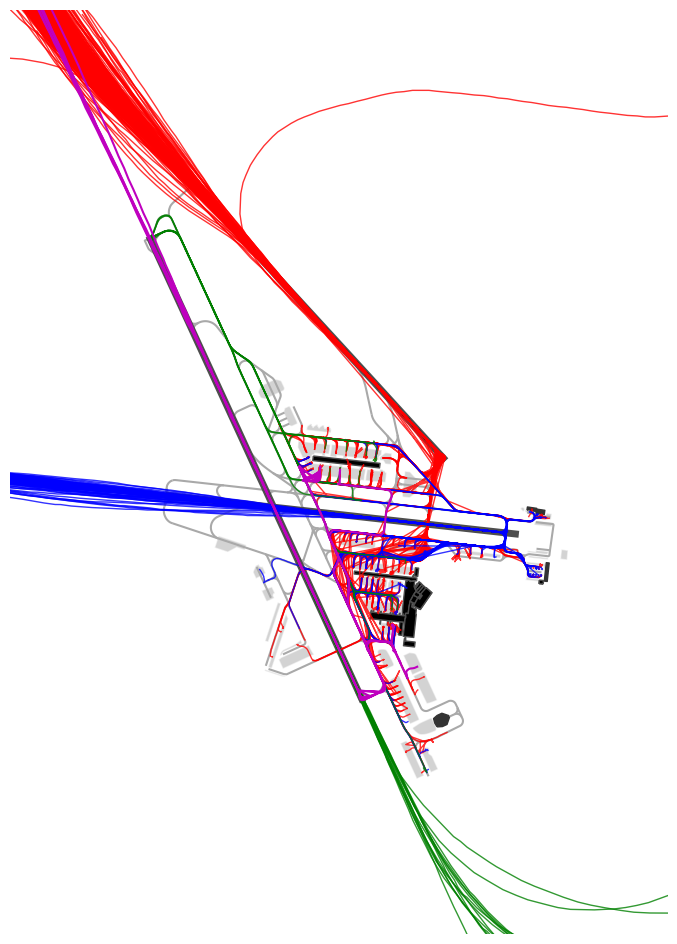

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
ax.spines["geo"].set_visible(False)

# gnd_trajs['XAFTY_016'].plot(ax=ax, color='r')

gnd_trajs[df_movements.query('takeoff_runway == "32"').flight_id.values].plot(ax=ax, color='r')
gnd_trajs[df_movements.query('takeoff_runway == "28"').flight_id.values].plot(ax=ax, color='b')
gnd_trajs[df_movements.query('takeoff_runway == "16"').flight_id.values].plot(ax=ax, color='g')
gnd_trajs[df_movements.query('takeoff_runway == "34"').flight_id.values].plot(ax=ax, color='m')
# gnd_trajs[df_movements.query('TO_runway == "10"').flight_id.values].plot(ax=ax, color='y')

ax.set_extent((8.5230, 8.5855, 47.4904, 47.4306))

### Plot taxi-part of trajs only

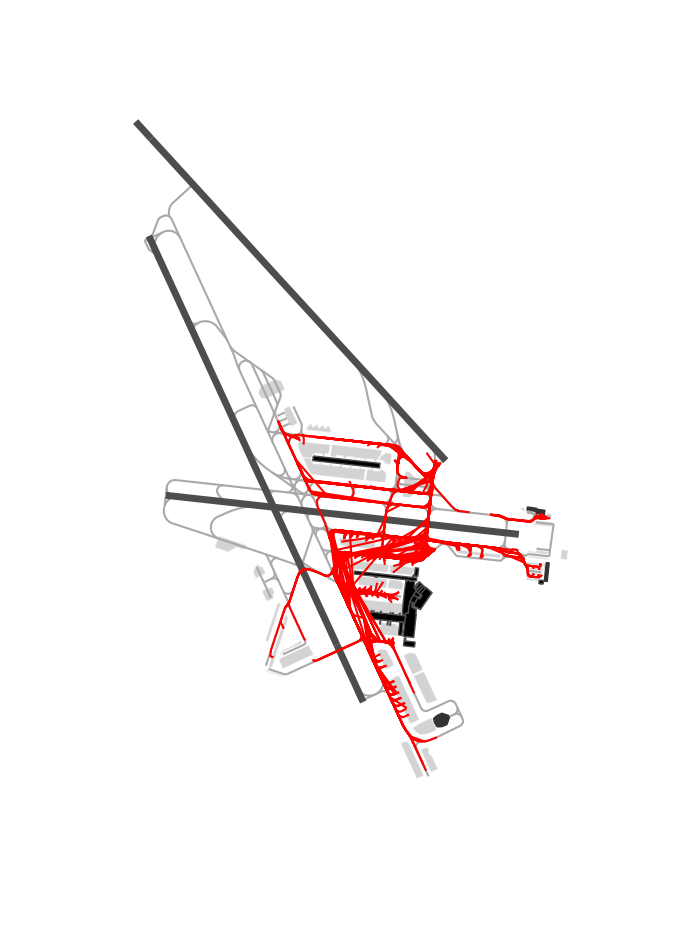

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
ax.spines["geo"].set_visible(False)


df_movements_rwy = df_movements.query('TO_runway == "32"')

flt_ids = df_movements_rwy.flight_id.values


for i, flt_id in enumerate(flt_ids):
    gnd_trajs[flt_id].between(df_movements_rwy.iloc[i].taxi_start, df_movements_rwy.iloc[i].line_up_time).plot(ax=ax, color='r')

ax.set_extent((8.5230, 8.5855, 47.4904, 47.4306))

In [50]:
# Plot Takeoffs only

from matplotlib.backends.backend_pdf import PdfPages

idxs = df_movements.index
number_of_pages = 40
number_of_trajs_per_page = 5

colors = ['r', 'b', 'g', 'y', 'c']

# Create a PDF file
with PdfPages('check_flights.pdf') as pdf:

    np.random.seed()

    for page in range(number_of_pages):

        ids = np.random.choice(idxs, size=number_of_trajs_per_page, replace=False)

        fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
        airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
        ax.spines["geo"].set_visible(False)
        ax.set_extent((8.5230, 8.5855, 47.4904, 47.4306))

        for i, idx in enumerate(ids):
            
            id = df_movements.loc[idx, 'flight_id']

            gnd_trajs[id].plot(ax=ax, color=colors[i], label=id)

            gnd_trajs[id].between(df_movements.iloc[idx].startTaxi, df_movements.iloc[idx].lineupTime).plot(ax=ax, color=colors[i], linewidth=3)

            if df_movements.loc[idx, 'isPushback']:
                gnd_trajs[id].between(df_movements.iloc[idx].startPushback, df_movements.iloc[idx].startTaxi).plot(ax=ax, color='m', linewidth=3)
            

        plt.legend(loc='upper right')
        pdf.savefig()  # saves the current figure into the pdf
        plt.close()  # close the figure after saving to pdf

 

In [54]:
# Plot Takeoffs and Landings

from matplotlib.backends.backend_pdf import PdfPages

flight_ids = gnd_trajs.data.flight_id.unique()
idxs = np.arange(len(flight_ids))

number_of_pages = 10
number_of_trajs_per_page = 5

colors = ['r', 'b', 'g', 'y', 'c']

# Create a PDF file
with PdfPages('check_flights.pdf') as pdf:

    np.random.seed()

    for page in range(number_of_pages):

        ids = np.random.choice(idxs, size=number_of_trajs_per_page, replace=False)

        fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
        airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
        ax.spines["geo"].set_visible(False)
        ax.set_extent((8.5230, 8.5855, 47.4904, 47.4306))

        for i, idx in enumerate(ids):

            id = flight_ids[idx]

            if gnd_trajs[id].data.isTakeoff.iloc[0]:

                Designator = gnd_trajs[id].data.takeoffRunway.iloc[0]

                gnd_trajs[id].plot(ax=ax, color=colors[i], label=id + ' RWY' + Designator)

                mov_idx = df_movements.loc[df_movements['flight_id'] == id].index.values[0]

                gnd_trajs[id].between(df_movements.iloc[mov_idx].startTaxi, 
                                      df_movements.iloc[mov_idx].lineupTime).plot(ax=ax, color=colors[i], linewidth=3)

                if df_movements.loc[mov_idx, 'isPushback']:
                    gnd_trajs[id].between(df_movements.iloc[mov_idx].startPushback, 
                                          df_movements.iloc[mov_idx].startTaxi).plot(ax=ax, color='m', linewidth=3)
            
            else:
                gnd_trajs[id].plot(ax=ax, color=colors[i], linestyle='--', label=id)

                

        plt.legend(loc='upper right')
        pdf.savefig()  # saves the current figure into the pdf
        plt.close()  # close the figure after saving to pdf



In [64]:
flight_ids = gnd_trajs.data.query('~isTakeoff').flight_id.unique()
idxs = np.arange(len(flight_ids))
idxs

array([   0,    1,    2, ..., 1254, 1255, 1256])

In [72]:
# Plot Non-Takeoffs only

flight_ids = gnd_trajs.data.query('~isTakeoff').flight_id.unique()
idxs = np.arange(len(flight_ids))

number_of_pages = 30
number_of_trajs_per_page = 5

colors = ['r', 'b', 'g', 'y', 'c']


# Create a PDF file
with PdfPages('check_flights.pdf') as pdf:

    np.random.seed()

    for page in range(number_of_pages):

        ids = np.random.choice(idxs, size=number_of_trajs_per_page, replace=False)

        fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
        airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
        ax.spines["geo"].set_visible(False)
        ax.set_extent((8.5230, 8.5855, 47.4904, 47.4306))

        for i, idx in enumerate(ids):

            id = flight_ids[idx]

            gnd_trajs[id].plot(ax=ax, color=colors[i], linestyle='--', label=id)

        plt.legend(loc='upper right')
        pdf.savefig()  # saves the current figure into the pdf
        plt.close()  # close the figure after saving to pdf


***
# Fuel Consumption Estimation
***


The process definition (main engine start, taxi, pushback, etc.) is based on information provided in Fleuti and Marinani (2017):
https://www.flughafen-zuerich.ch/-/jssmedia/airport/portal/dokumente/das-unternehmen/politics-and-responsibility/environmental-protection/technische-berichte/2017_taxi_study_zurichairport.pdf?vs=1


## Engine Fuel Consumption

Fleuti: According to the ICAO certification LTO definition, the phase of taxi or idle is assumed to be at a uniform 7% thrust of the engine. The fuel flow – and the resulting emissions – have been measured and certified at this thrust level. --> This corresponds to the "idle thrust" setting reported in the ICAO Engine Emissions Databank.

ICAO Engine Emissions Databank


## APU Fuel Consumption
ICAO Document 9889
ICAO Document 9889 7.2 Unlike aircraft main engines, APUs are not certificated for emissions, and the manufacturers generally
consider information on APU emissions rates as proprietary. As a result, little data are publicly available to serve as a
basis for calculating APU emissions.

ICAO Document 9889 Table 3-A1-5:
| Mode           | Two Engine A/C                  | Four Engine A/C               |
|----------------|---------------------------------|-------------------------------|
| Start-up       | 3 minutes                       | 3 minutes                     | 
| Normal Running | Pre-dep. running time: 3.6min   | Pre-dep. running time: 5.3min |
| High-load      | Engine start: 35 seconds        | Engine start: 140 seconds     |


## AGPS Fuel

In [33]:
#df_movements = pd.read_pickle('df_movements_JUL24.pkl')
df_movements = pd.read_pickle('df_movements.pkl')
df_movements

,flight_id,callsign,isPushback,startPushback,startTaxi,lineupTime,taxiDuration,taxiDistance,takeoffRunway,typecode
0,9AJIM_1791,9AJIM,False,NaT,2024-06-02 18:21:44+00:00,2024-06-02 18:25:05+00:00,0 days 00:03:21,0.567781,32,C525
1,AAL93_1964,AAL93,True,2024-06-01 09:43:45+00:00,2024-06-01 09:45:08+00:00,2024-06-01 09:55:12+00:00,0 days 00:10:04,0.703120,28,B788
2,AAL93_1966,AAL93,True,2024-06-02 09:50:42+00:00,2024-06-02 09:52:13+00:00,2024-06-02 10:03:36+00:00,0 days 00:11:23,0.759994,28,B788
3,ACA881_1975,ACA881,True,2024-06-02 11:30:45+00:00,2024-06-02 11:32:02+00:00,2024-06-02 11:42:24+00:00,0 days 00:10:22,1.444709,16,B77W
4,ACA881_1978,ACA881,True,2024-06-01 11:28:38+00:00,2024-06-01 11:28:59+00:00,2024-06-01 11:39:38+00:00,0 days 00:10:39,1.326674,16,A333
...,...,...,...,...,...,...,...,...,...,...
718,VLG5YD_047,VLG5YD,False,NaT,2024-06-02 07:39:15+00:00,2024-06-02 07:43:11+00:00,0 days 00:03:56,0.739248,28,A320
719,VPBIB_192,VPBIB,False,NaT,2024-06-02 14:18:27+00:00,2024-06-02 14:42:43+00:00,0 days 00:24:16,0.172802,28,C25C
720,VQBHK_194,VQBHK,False,NaT,2024-06-02 08:20:11+00:00,2024-06-02 08:24:08+00:00,0 days 00:03:57,0.868492,28,None
721,VTTUS_1927,VTTUS,False,NaT,2024-06-02 12:25:44+00:00,2024-06-02 12:35:22+00:00,0 days 00:09:38,0.698260,28,None


In [5]:
# ICAO Document 9889 Table 3-A1-5: APU Fuel Groups ("Advanced approach to calculate fuel consumption")

import agps_funs
# importlib.reload(agps_funs)
from openap import prop

df_apu = agps_funs.dfAPUfuel()
df_apu

,APU fuel group,startup,normal,high
0,Business jets/regional jets (seats < 100),68,101,110
1,"Smaller (100 ≤ seats < 200), newer types",77,110,130
2,"Smaller (100 ≤ seats < 200), older types",69,122,130
3,"Mid-range (200 ≤ seats < 300), all types",108,164,191
4,"Larger (300 ≤ seats), older types",106,202,214
5,"Larger (300 ≤ seats), newer types",146,238,262


### Calculate FF due to normal taxi w/ and w/o push-back

In [70]:
from agps_config import AC2CONSIDER

def estimateNormalFuel(mov) -> tuple:
    """
    Estimates the normal fuel consumption for an aircraft during various ground operations.

    This function calculates the fuel consumption for three key phases of ground operation:
    - Main Engine Start (MES) using the engine.
    - Main Engine Start (MES) using the Auxiliary Power Unit (APU).
    - Taxiing using the main engines.

    The function checks if the aircraft type (`typecode`) is listed in the `AC2CONSIDER` set. If it is,
    it estimates the fuel consumption for each phase using the corresponding functions from the `agps_funs` module.
    If the aircraft type is not considered, the function returns NaN for all fuel consumption estimates.

    Args:
        mov: An object representing the aircraft movement data, which should have the following attributes:
            - typecode (str): The ICAO typecode of the aircraft.
            - startTaxi (datetime): The timestamp when the aircraft starts taxiing.
            - lineupTime (datetime): The timestamp when the aircraft reaches the lineup position for takeoff.

    Returns:
        tuple: A tuple containing three elements:
            - consMESengine (float): Estimated fuel consumption in kilograms for the Main Engine Start using the engine.
            - consMESapu (float): Estimated fuel consumption in kilograms for the Main Engine Start using the APU.
            - consTaxiEngine (float): Estimated fuel consumption in kilograms for taxiing using the main engines.
            If the aircraft type is not in `AC2CONSIDER`, all values will be NaN.

    Example:
        mov = Movement(typecode='A320', startTaxi='2024-06-01 09:45:08+00:00', lineupTime='2024-06-01 09:55:12+00:00')
        consMESengine, consMESapu, consTaxiEngine = estimateNormalFuel(mov)
        print(consMESengine, consMESapu, consTaxiEngine)

    Notes:
        - The actual fuel consumption estimates are dependent on the functions provided in the `agps_funs` module.
        - The aircraft movement data object (`mov`) must have the required attributes (`typecode`, `startTaxi`, `lineupTime`) for the function to work correctly.
    """

    consMESengine = np.nan
    consMESapu = np.nan
    consTaxiEngine = np.nan

    if mov.typecode in AC2CONSIDER:
        consMESengine = agps_funs.fuelMESengine(mov.typecode)
        consMESapu = agps_funs.fuelMESapu(mov.typecode)
        consTaxiEngine = agps_funs.fuelTaxiEngine(mov.typecode, mov.startTaxi, mov.lineupTime)


    return consMESengine, consMESapu, consTaxiEngine

### Calculate Consumption with External AGPS

(without considering operational constraints, e.g. where to disconnect AGPS)

**Variables**:
* Warmup time (Default: Engine warm up if shut down for less than two hours is 2 minutes at idle, if shutdown for more than two hours warmup is 5 minutes at idle, according to https://www.pprune.org/archive/index.php/t-624084.html)
* Minimum AGPS-Time

In [67]:
from agps_config import DEFAULT_STARTUP_TIME, DEFAULT_WARMUP_TIME, AC2CONSIDER

def estimateExtAGPS(mov, 
                    minAGPSDuration=datetime.timedelta(seconds=300),
                    takeoffRunway=None,  # Default to None
                    startupTime=DEFAULT_STARTUP_TIME, 
                    warmupTime=DEFAULT_WARMUP_TIME) -> tuple:
    """
    Estimates the fuel consumption for various phases of aircraft ground operation.

    Args:
        movement: An object representing the aircraft movement data.
        minAGPSDuration (datetime.timedelta, optional): Minimum AGPS duration to consider. Defaults to 300 seconds.
        takeoffRunway (list or None, optional): List of takeoff runways to consider. If None, all runways are considered.
                                                Defaults to None.
        startupTime (int, optional): The time in seconds for engine startup. Defaults to DEFAULT_STARTUP_TIME.
        warmupTime (int, optional): The time in seconds for engine warm-up. Defaults to DEFAULT_WARMUP_TIME.

    Returns:
        tuple: A tuple containing fuel consumption estimates for MES engine, MES APU, ECS APU, and taxi engine.
    """

    consMESengine = np.nan
    consMESapu = np.nan
    consECSapu = np.nan
    consTaxiEngine = np.nan

    # Check if the aircraft type is in AC2CONSIDER
    if mov.typecode in AC2CONSIDER:
        taxiDuration = mov.lineupTime - mov.startTaxi
        MESDuration = agps_funs.getMESduration(mov.typecode, startupTime=startupTime, warmupTime=warmupTime)

        AGPSDuration = taxiDuration - MESDuration

        # Calculate Main Engine Start fuel consumption
        consMESengine = agps_funs.fuelMESengine(mov.typecode, startupTime=startupTime, warmupTime=warmupTime)
        consMESapu = agps_funs.fuelMESapu(mov.typecode, startupTime=startupTime, warmupTime=warmupTime)

        # Check if we should consider this movement based on the takeoffRunway parameter
        if (AGPSDuration > minAGPSDuration) and (takeoffRunway is None or mov.takeoffRunway in takeoffRunway):
            consECSapu = agps_funs.fuelECSapu(mov.typecode, agpsDuration=AGPSDuration)
            consTaxiEngine = np.nan
        else:
            consECSapu = np.nan
            consTaxiEngine = agps_funs.fuelTaxiEngine(mov.typecode, mov.startTaxi, mov.lineupTime)

    return consMESengine, consMESapu, consECSapu, consTaxiEngine

In [86]:
import traceback

# Function to perform calculations for a given minAGPSDuration
def calculate_sensitivity(min_duration_seconds):
    """
    Calculates fuel consumption sensitivity based on a specified minimum AGPS duration.

    This function estimates the total fuel consumption for different phases of aircraft ground operations
    for all takeoff runways and specifically for runway '16', based on a provided minimum AGPS (Auxiliary Power
    Unit Ground Power Supply) duration in seconds. It performs calculations by applying the `estimateExtAGPS`
    function to each row of a copy of the `df_movements` DataFrame.

    The function returns the total fuel consumption across all runways and for runway '16' for the specified
    AGPS duration.

    Args:
        min_duration_seconds (int): The minimum AGPS duration in seconds to consider for fuel consumption calculations.

    Returns:
        dict: A dictionary containing the following keys:
            - 'minAGPSDuration': The minimum AGPS duration provided in seconds.
            - 'total_fuel_consumption_all': The total estimated fuel consumption for all runways.
            - 'total_fuel_consumption_runway16': The total estimated fuel consumption specifically for runway '16'.

    Example:
        result = calculate_sensitivity(300)
        print(result)
        # Output: {'minAGPSDuration': 300, 'total_fuel_consumption_all': 1234.5, 'total_fuel_consumption_runway16': 678.9}

    Notes:
        - The function makes a copy of the global DataFrame `df_movements` to avoid modifying the original data.
        - The `estimateExtAGPS` function is applied twice: first for all runways, and then specifically for runway '16'.
        - If an exception occurs during processing, the function prints an error message and returns None.
        - Ensure that the `df_movements` DataFrame and `estimateExtAGPS` function are properly defined and accessible
          in the global scope before calling this function.
    """
    
    try:
        # Copy of the dataframe to avoid modification issues
        df_copy = df_movements.copy()
        
        # Apply the function for all runways with the specific minAGPSDuration
        df_copy[['EAGPS_MES_Eng', 'EAGPS_MES_APU', 'EAGPS_ECS_APU', 'EAGPS_Taxi_Eng']] = df_copy.apply(
            estimateExtAGPS, 
            axis=1, 
            result_type='expand', 
            minAGPSDuration=datetime.timedelta(seconds=int(min_duration_seconds))
        )

        # Calculate the sum of the specified columns for all runways
        total_fuel_consumption_all = df_copy[['EAGPS_MES_Eng', 'EAGPS_MES_APU', 'EAGPS_ECS_APU', 'EAGPS_Taxi_Eng']].sum().sum()

        # Apply the function only for takeoffRunway=['16'] with the specific minAGPSDuration
        df_copy[['EAGPS_MES_Eng', 'EAGPS_MES_APU', 'EAGPS_ECS_APU', 'EAGPS_Taxi_Eng']] = df_copy.apply(
            estimateExtAGPS, 
            axis=1, 
            result_type='expand', 
            minAGPSDuration=datetime.timedelta(seconds=int(min_duration_seconds)),
            takeoffRunway=['16']
        )

        # Calculate the sum of the specified columns for runway '16'
        total_fuel_consumption_runway16 = df_copy[['EAGPS_MES_Eng', 'EAGPS_MES_APU', 'EAGPS_ECS_APU', 'EAGPS_Taxi_Eng']].sum().sum()

        # Return both results in a single dictionary
        return {
            'minAGPSDuration': min_duration_seconds,
            'total_fuel_consumption_all': total_fuel_consumption_all, 
            'total_fuel_consumption_runway16': total_fuel_consumption_runway16
        }

    except Exception as e:
        print(f"Error in calculating sensitivity for min_duration_seconds={min_duration_seconds}")
        print(traceback.format_exc())
        return None

In [97]:
from multiprocessing.dummy import Pool as ThreadPool
from tqdm import tqdm
import pandas as pd

def run_multiprocessing(min_agps_durations, num_workers=4):
    """
    Executes parallel processing to calculate fuel consumption sensitivity for multiple AGPS durations.

    This function uses multithreading to perform parallel computations of fuel consumption sensitivity
    across a range of minimum AGPS (Auxiliary Power Unit Ground Power Supply) durations. It applies the
    `calculate_sensitivity` function to each value in `min_agps_durations` using a thread pool, which 
    allows for concurrent execution and improves performance on multi-core systems.

    The results are gathered into a list, converted into a pandas DataFrame, and sorted by the minimum AGPS 
    duration for easy analysis.

    Args:
        min_agps_durations (iterable of int): A list or array of minimum AGPS durations in seconds to be processed.
        num_workers (int, optional): The number of threads to use for parallel processing. Defaults to 4.

    Returns:
        pandas.DataFrame: A DataFrame containing the sensitivity results for each AGPS duration, sorted by 
        'minAGPSDuration'. Each row represents a different AGPS duration and includes calculated fuel 
        consumption metrics for all runways and specifically for runway '16'.

    Example:
        min_agps_durations = [60, 120, 180, 240, 300]
        sensitivity_df = run_multiprocessing(min_agps_durations, num_workers=4)
        print(sensitivity_df)
        # Output will be a DataFrame with columns like 'minAGPSDuration', 'total_fuel_consumption_all', 'total_fuel_consumption_runway16'

    Notes:
        - This function uses `multiprocessing.dummy.Pool`, which is a thread-based pool, to avoid issues related
          to process-based multiprocessing in Jupyter notebooks and to make the best use of available cores for I/O-bound tasks.
        - The progress of the computation is tracked and displayed using `tqdm` to provide a visual indicator of the 
          processing status.
        - Ensure that the `calculate_sensitivity` function is defined and accessible in the global scope before calling 
          this function.
    """
    
    sensitivity_results = []

    # Use ThreadPool for parallel processing with a specific number of threads
    with ThreadPool(num_workers) as pool:
        # Use imap_unordered to get results as they complete
        for result in tqdm(pool.imap_unordered(calculate_sensitivity, min_agps_durations), total=len(min_agps_durations), desc='Processing minAGPSDurations'):
            if result is not None:
                sensitivity_results.append(result)

    # Convert the results to a single DataFrame for easy analysis & sort according to minAGPSDuration
    sensitivity_df = pd.DataFrame(sensitivity_results)
    sensitivity_df = sensitivity_df.sort_values(by='minAGPSDuration')

    return sensitivity_df

# Calculate sensitivity of results for change in minimum AGPS duration
min_agps_durations = np.arange(60, 601, 60)
sensitivity_df = run_multiprocessing(min_agps_durations=min_agps_durations, num_workers=8)



Processing minAGPSDurations: 100%|██████████| 10/10 [05:26<00:00, 32.64s/it]


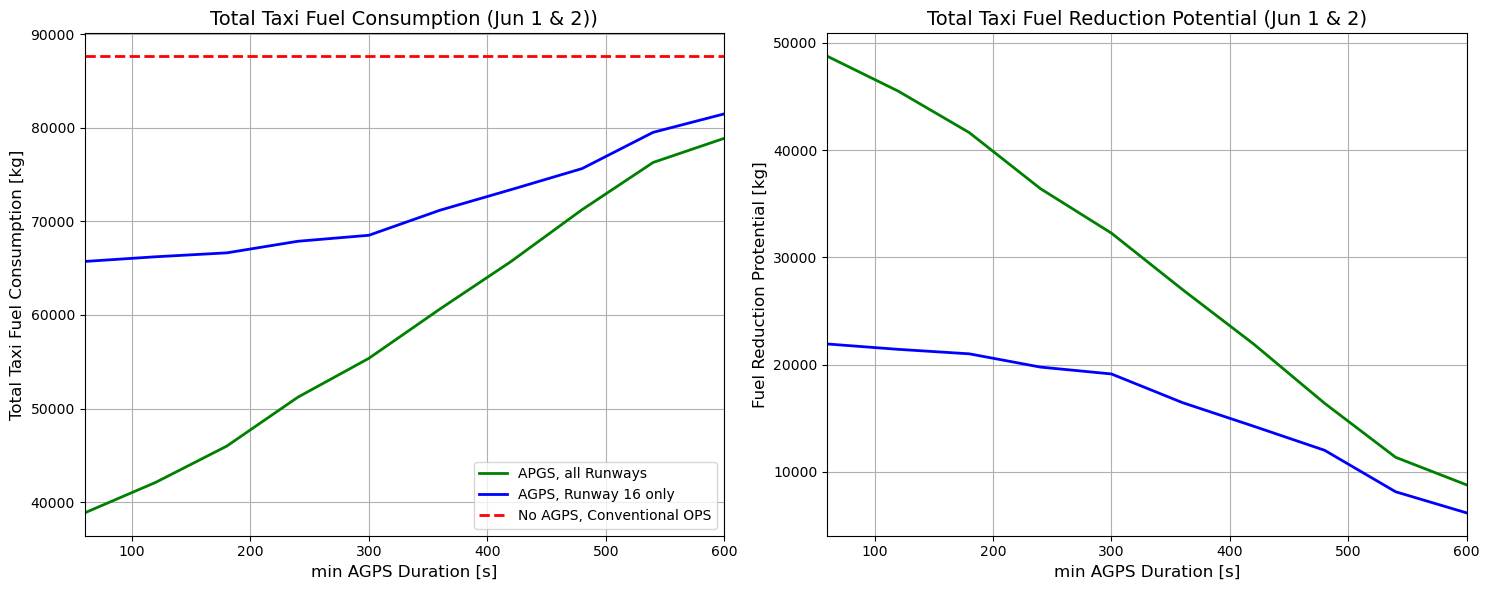

In [103]:
totalFuelNormal = df_movements['NORM_MES_Eng'].sum() + df_movements['NORM_MES_APU'].sum() + df_movements['NORM_Taxi_Eng'].sum()

# Plot the results to see how minAGPSDuration affects total fuel consumption
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(sensitivity_df['minAGPSDuration'], 
            sensitivity_df['total_fuel_consumption_all'], 
            color = 'g',
            label='APGS, all Runways',
            linewidth = 2)

axs[0].plot(sensitivity_df['minAGPSDuration'],
            sensitivity_df['total_fuel_consumption_runway16'],
            color= 'b',
            label='AGPS, Runway 16 only',
            linewidth = 2)

# Add a horizontal line at a specific y-value (e.g., y=1000)
axs[0].axhline(y=totalFuelNormal, color='r', linestyle='--', linewidth=2, label='No AGPS, Conventional OPS')

axs[0].set_xlim((60, 600))

# Customize the plot
axs[0].set_title('Total Taxi Fuel Consumption (Jun 1 & 2))', fontsize=14)
axs[0].set_xlabel('min AGPS Duration [s]', fontsize=12)
axs[0].set_ylabel('Total Taxi Fuel Consumption [kg]', fontsize=12)
axs[0].grid(True)
axs[0].legend()


axs[1].plot(sensitivity_df['minAGPSDuration'], 
            totalFuelNormal - sensitivity_df['total_fuel_consumption_all'],
            color = 'g',
            label='APGS, all Runways',
            linewidth = 2)


axs[1].plot(sensitivity_df['minAGPSDuration'], 
            totalFuelNormal - sensitivity_df['total_fuel_consumption_runway16'],
            color= 'b',
            label='AGPS, Runway 16 only',
            linewidth = 2)

axs[1].set_xlim((60, 600))
axs[1].set_title('Total Taxi Fuel Reduction Potential (Jun 1 & 2)', fontsize=14)
axs[1].set_xlabel('min AGPS Duration [s]', fontsize=12)
axs[1].set_ylabel('Fuel Reduction Protential [kg]', fontsize=12)
axs[1].grid(True)



plt.tight_layout()
# Save the figure as a PDF
plt.savefig('taxi_fuel_JUL24.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


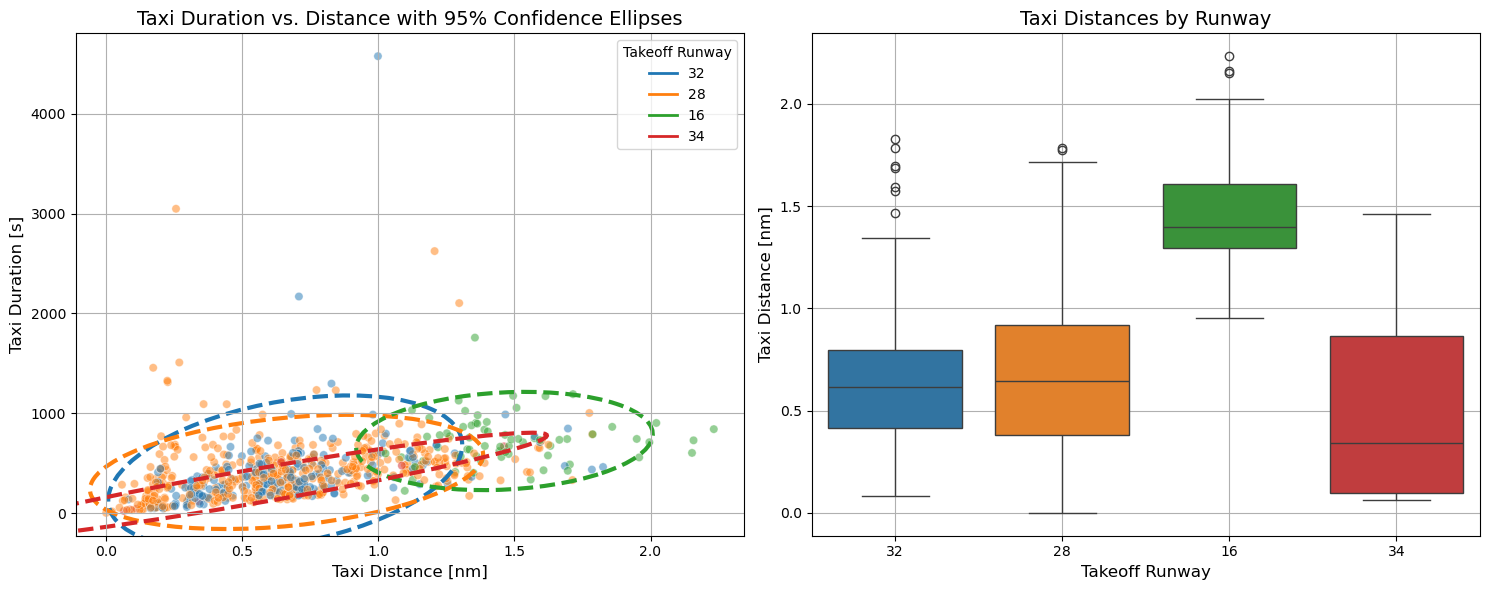

In [99]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D
import seaborn as sns

# Convert taxiDuration to total seconds for scatter plotting
df_movements['taxiDuration_seconds'] = df_movements['taxiDuration'].dt.total_seconds()

# Filter out rows where takeoffRunway is "10"
df_filtered = df_movements[df_movements['takeoffRunway'] != '10']

# Set a nicer color palette
sns.set_palette("tab10")

# Function to draw an ellipse representing the 95% confidence interval
def confidence_ellipse(x, y, ax, n_std=1.96, edgecolor='black', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radii.

    edgecolor : str
        The color of the ellipse's edge.

    kwargs : dict
        Additional keyword arguments to `matplotlib.patches.Ellipse`.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, edgecolor=edgecolor, facecolor='none', linewidth=3, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    transf = (
        transforms.Affine2D()
        .rotate_deg(45)
        .scale(scale_x, scale_y)
        .translate(mean_x, mean_y)
    )

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Left subplot: Scatter plot of Taxi Duration vs. Taxi Distance colored by takeoffRunway
scatter = sns.scatterplot(
    data=df_filtered,
    x='taxiDistance', 
    y='taxiDuration_seconds', 
    hue='takeoffRunway', 
    palette='tab10',  # Use a nicer color palette
    ax=axs[0],
    alpha=0.5,  # Set scatter points with slight alpha
    legend=False
)

# Add 95% confidence ellipses for each runway
palette = sns.color_palette("tab10")  # Get the current color palette
runway_colors = {runway: palette[i] for i, runway in enumerate(df_filtered['takeoffRunway'].unique())}

for runway in df_filtered['takeoffRunway'].unique():
    subset = df_filtered[df_filtered['takeoffRunway'] == runway]
    confidence_ellipse(
        subset['taxiDistance'], 
        subset['taxiDuration_seconds'],
        axs[0], 
        edgecolor=runway_colors[runway],
        linestyle='--',
        alpha=1,
    )

axs[0].set_xlabel('Taxi Distance [nm]', fontsize = 12)
axs[0].set_ylabel('Taxi Duration [s]', fontsize = 12)
axs[0].set_title('Taxi Duration vs. Distance with 95% Confidence Ellipses', fontsize=14)
axs[0].grid(True)

# Create custom legend handles for the ellipses
custom_lines = [Line2D([0], [0], color=runway_colors[runway], lw=2) for runway in df_filtered['takeoffRunway'].unique()]
axs[0].legend(custom_lines, df_filtered['takeoffRunway'].unique(), title='Takeoff Runway')


# Right subplot: Box plot of Taxi Distances for each runway
sns.boxplot(
    data=df_filtered,
    x='takeoffRunway',
    y='taxiDistance',
    palette='tab10',  # Use the same color palette
    ax=axs[1]
)
axs[1].set_xlabel('Takeoff Runway', fontsize = 12)
axs[1].set_ylabel('Taxi Distance [nm]', fontsize = 12)
axs[1].set_title('Taxi Distances by Runway', fontsize=14)
axs[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('taxi_distance_duration.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()